In [1]:
# -*- coding: utf-8 -*-
# Licensed under a 3-clause BSD style license - see LICENSE.rst
import logging
import os
import warnings
from collections import OrderedDict
from multiprocessing import Pool

import astropy
from astropy.table import Table, hstack
import astropy.units as u
from astropy.io import ascii
from astropy.constants import alpha, c, e, hbar, m_e, m_p, sigma_sb
from astropy.utils.data import get_pkg_data_filename
from astropy.cosmology import WMAP9 as cosmo


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from Validator import (
    validate_array,
    validate_physical_type,
    validate_scalar,
)
#from .model_utils import memoize
from Utils import trapz_loglog

import Models
import Radiative
import grbloader
from GRBmodel import GRBModel1
from Models import EblAbsorptionModel

from astropy.units import def_physical_type

try:
    #def_physical_type(u.Unit("1 / eV"), "differential energy")
    def_physical_type(u.erg / u.cm**2 / u.s, "flux")
    def_physical_type(u.Unit("1/(s cm2 erg)"), "differential flux")
    def_physical_type(u.Unit("1/(s erg)"), "differential power")
    def_physical_type(u.Unit("1/TeV"), "differential energy")
    def_physical_type(u.Unit("1/cm3"), "number density")
    def_physical_type(u.Unit("1/(eV cm3)"), "differential number density")

except ValueError:
    print("New quantities already defined")

New quantities already defined


In [2]:
Eiso = 8e51  # erg
density = 0.5  # cm-3
redshift = 0.0004
tstart = 68   # s
tstop = 110   # s

#-----list of parameters of a electron distribution (log10) ------

eta_e=-1.44
Ebreak=-1.62
Index2=3.17
Ec=1.32  # cutoff energy in TeV
B=0.29
#B=100*u.uG

Dl = cosmo.luminosity_distance(redshift).to(u.kpc)
print(Dl)

1730.447689808629 kpc


In [3]:
emin=1e-3
emax=1e16
bins = int(np.log10(emax/emin) * 20.)  # use 20 bins per decade
ener = Table([np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV], names=['energy'])  # energy in eV
#---------------------------------------------------------------------------
    
"""
Initialize the GRBModelling class with the data and the given parameters
"""
grb = GRBModel1(eiso=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)

grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)


the code can be used only for computation of theoretical curves

 ------------------ Starting GRB initialization ------------------
Gamma 63.40686227993884
 ------------------ Ending GRB initialization ------------------


-------------------- Starting GRB computation --------------------
Theta max (deg): 3.6144844550183652  = 4\Gamma
Gamma factor ISO : 63.40686227993884
 Doppler factor(theta) [126.80583849 105.89274148  70.84271012  45.65662944  30.48439136
  21.35912901  15.63817449  11.87847173   9.29913464   7.4628059 ]
-------------------- ending GRB computation --------------------



(<Quantity [7.34637269e-12, 8.56491259e-12, 9.98520097e-12, 1.16405427e-11,
            1.35697147e-11, 1.58178584e-11, 1.84375158e-11, 2.14898313e-11,
            2.50459471e-11, 2.91886203e-11, 3.40140969e-11, 3.96342836e-11,
            4.61792605e-11, 5.38001886e-11, 6.26726707e-11, 7.30006337e-11,
            8.50208085e-11, 9.90078958e-11, 1.15280516e-10, 1.34208053e-10,
            1.56218521e-10, 1.81807587e-10, 2.11548912e-10, 2.46105975e-10,
            2.86245572e-10, 3.32853199e-10, 3.86950532e-10, 4.49715242e-10,
            5.22503402e-10, 6.06874730e-10, 7.04620925e-10, 8.17797360e-10,
            9.48758340e-10, 1.10019615e-09, 1.27518398e-09, 1.47722291e-09,
            1.71029272e-09, 1.97890651e-09, 2.28816869e-09, 2.64383568e-09,
            3.05237847e-09, 3.52104578e-09, 4.05792617e-09, 4.67200707e-09,
            5.37322806e-09, 6.17252555e-09, 7.08186526e-09, 8.11425871e-09,
            9.28375981e-09, 1.06054374e-08, 1.20953204e-08, 1.37703120e-08,
            

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


---------------------------------------------------------------------------------------------------
Γ factor = 63.40686227993884
η_B = 0.025029284297040204
η_e = 0.03630780547701014
Shell Radius 8.581697887600152e+16 cm
---------------------------------------------------------------------------------------------------
Plot saved as: /media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/SED_SSC Approx vs True.jpg.png/pdf


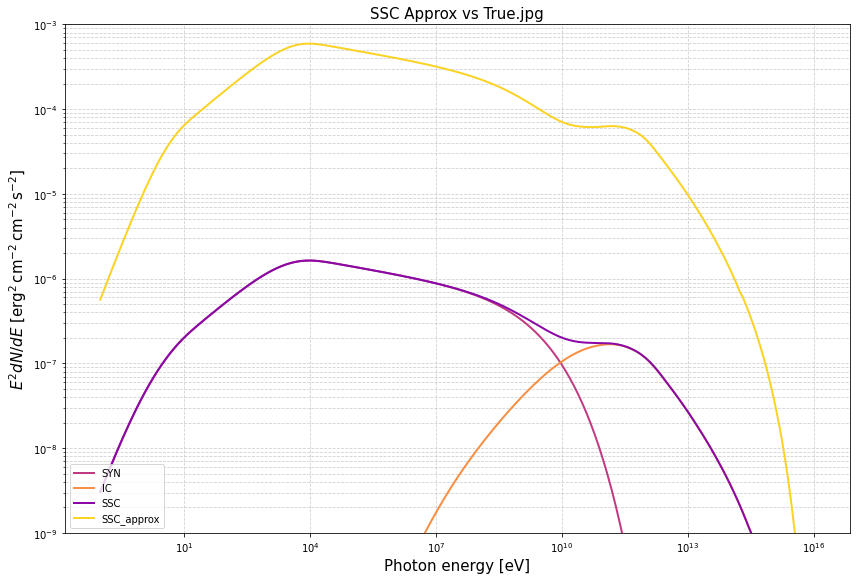

In [4]:
path="/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/"
grb.plot_sed(1e-1,1e16,order_bottom=6, Save=True, Path=path, Name='SSC Approx vs True.jpg')

### Comparinson with the NSBH prediction?

In [5]:
#from astropy.cosmology import Planck18
z=0.1

n0=0.001,    # circumburst density in cm^{-3}
p= 2.3,    # electron energy distribution index
epsilon_e=0.2,    # epsilon_e
epsilon_B=0.02, # 4*10**(-3),   # epsilon_B
#d_L= Planck18.luminosity_distance(z).value*3.086*10**24, # Luminosity distance in cm 1.8e28
Eiso = 8e51  # erg


In [6]:
Eiso = 8e51  # erg
density = 0.01  # cm-3
redshift = 0.1
tstart = 68   # s
tstop = 108   # s

#-----list of parameters of a electron distribution (log10) ------

eta_e=-1.44
Ebreak=-1.62
Index2=3.3
Ec=1.32  # cutoff energy in TeV
B=0.8

In [7]:
emin=1e-9
emax=1e14
bins = int(np.log10(emax/emin) * 20.)  # use 20 bins per decade
ener = Table([np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV], names=['energy'])  # energy in eV

grb = GRBModel1(eiso=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)

grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)

the code can be used only for computation of theoretical curves

 ------------------ Starting GRB initialization ------------------
Gamma 103.83595544667675
 ------------------ Ending GRB initialization ------------------


-------------------- Starting GRB computation --------------------
Theta max (deg): 2.2071653028706666  = 4\Gamma
Gamma factor ISO : 103.83595544667675
 Doppler factor(theta) [207.66709549 173.41476267 116.01101067  74.76414025  49.91761361
  34.97409935  25.60558787  19.44882771  15.22501575  12.21793328]
-------------------- ending GRB computation --------------------



(<Quantity [3.66998776e-25, 4.28032281e-25, 4.99215924e-25, 5.82237719e-25,
            6.79066402e-25, 7.91998118e-25, 9.23710873e-25, 1.07732803e-24,
            1.25649240e-24, 1.46545259e-24, 1.70916376e-24, 1.99340517e-24,
            2.32491717e-24, 2.71156105e-24, 3.16250550e-24, 3.68844398e-24,
            4.30184832e-24, 5.01726447e-24, 5.85165744e-24, 6.82481359e-24,
            7.95980983e-24, 9.28356087e-24, 1.08274575e-23, 1.26281107e-23,
            1.47282204e-23, 1.71775875e-23, 2.00342948e-23, 2.33660849e-23,
            2.72519660e-23, 3.17840859e-23, 3.70699167e-23, 4.32348039e-23,
            5.04249381e-23, 5.88108224e-23, 6.85913149e-23, 7.99983449e-23,
            9.33024122e-23, 1.08819002e-22, 1.26916066e-22, 1.48022748e-22,
            1.72639559e-22, 2.01350249e-22, 2.34835645e-22, 2.73889800e-22,
            3.19438822e-22, 3.72562832e-22, 4.34521580e-22, 5.06784318e-22,
            5.91064638e-22, 6.89361110e-22, 8.04004672e-22, 9.37713906e-22,
            

In [ ]:

print(grb.eta_b)

In [ ]:
grb.plot_sed_fast(1e-3,5e16,1e-14,1e-6)

---------------------------------------------------------------------------------------------------
Γ factor = 103.83595544667675
η_B = 4.886472215121118
η_e = 0.03630780547701014
Shell Radius 2.275563132336527e+17 cm
---------------------------------------------------------------------------------------------------


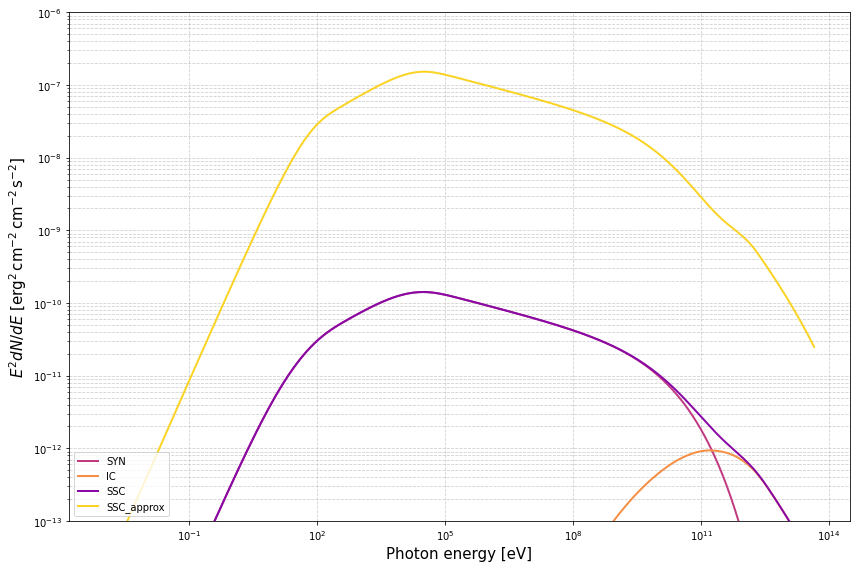

In [8]:
grb.plot_sed(1e-3,5e13,7)

## ------------------------------ Multiple plots -----------------------------------

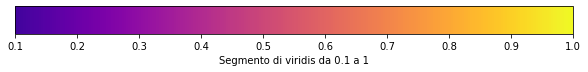

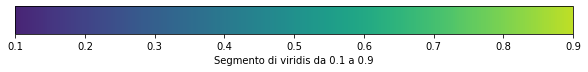

In [9]:
from matplotlib import cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

vmin = 0.1
vmax = 1
original_cmap = plt.cm.plasma

cmap1 = truncate_colormap(original_cmap, vmin, vmax)
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)
norm = Normalize(vmin, vmax)  # da 0 a 1 perché stai solo mostrando il segmento
cb = ColorbarBase(ax,cmap=cmap1,norm=norm,orientation='horizontal')
cb.set_label(f'Segmento di viridis da {vmin} a {vmax}')
plt.show()

vmin = 0.1
vmax = 0.9
original_cmap2 = plt.cm.viridis

cmap2 = truncate_colormap(original_cmap2, vmin, vmax)
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)
norm = Normalize(vmin, vmax)  # da 0 a 1 perché stai solo mostrando il segmento
cb = ColorbarBase(ax,cmap=cmap2,norm=norm,orientation='horizontal')
cb.set_label(f'Segmento di viridis da {vmin} a {vmax}')
plt.show()


In [10]:
############################################### PARAMETERS ####################################

Eiso = 8e51  # erg
density = 0.01 #0.5  # cm-3
redshift = 0.1
tstart = 68   # s
tstop = 110   # s

#-----list of parameters of a electron distribution (log10) ------

eta_e=-1.44
Ebreak=-1.62
Index2=3.3
Ec=1.32  # cutoff energy in TeV
B=0.25

#################################################################################################

In [11]:
multi_Eiso=np.logspace(49,52,10)
print(multi_Eiso)

[1.00000000e+49 2.15443469e+49 4.64158883e+49 1.00000000e+50
 2.15443469e+50 4.64158883e+50 1.00000000e+51 2.15443469e+51
 4.64158883e+51 1.00000000e+52]


the code can be used only for computation of theoretical curves

 ------------------ Starting GRB initialization ------------------
Gamma 106.32154150526293
 ------------------ Ending GRB initialization ------------------


-------------------- Starting GRB computation --------------------
Theta max (deg): 2.1555661703887607  = 4\Gamma
Gamma factor ISO : 106.32154150526293
 Doppler factor(theta) [212.63838019 177.5659941  118.78798257  76.55370955  51.1124088
  35.8111863   26.21842063  19.91428735  15.58937148  12.51030984]
-------------------- ending GRB computation --------------------

the code can be used only for computation of theoretical curves

 ------------------ Starting GRB initialization ------------------
Gamma 44.83542229190626
 ------------------ Ending GRB initialization ------------------


-------------------- Starting GRB computation --------------------
Theta max (deg): 5.111652937273698  = 4\Gamma
Gamma factor ISO : 44.83542229190626
 Doppler factor(theta) [89.659

No handles with labels found to put in legend.


-------------------- ending GRB computation --------------------



No handles with labels found to put in legend.


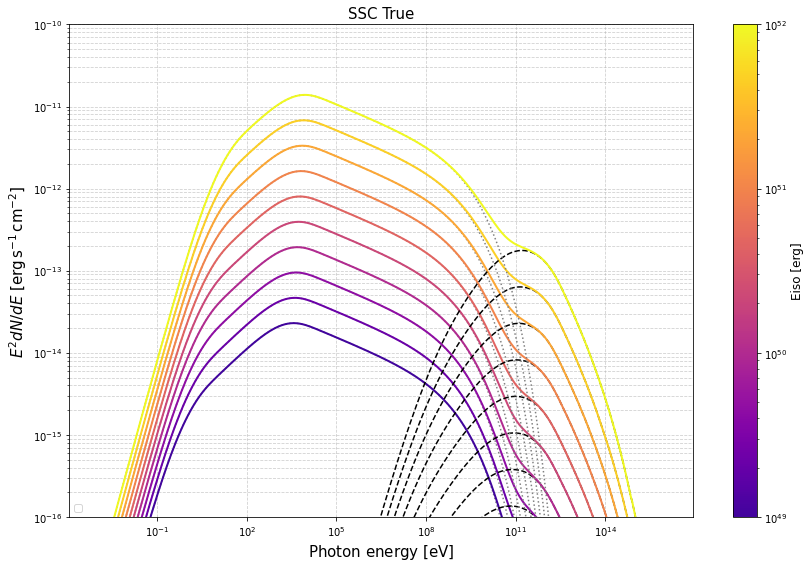

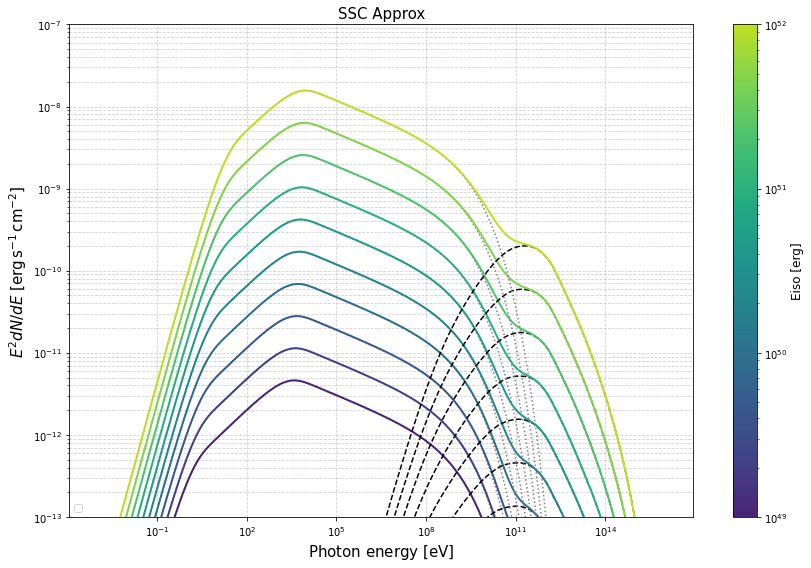

In [13]:
multi_Eiso=np.logspace(49,52,10)
norm = mcolors.LogNorm(vmin=np.min(multi_Eiso), vmax=np.max(multi_Eiso))

emin=1e-3
emax=1e16
bins = int(np.log10(emax/emin) * 20.)  # use 20 bins per decade
ener = Table([np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV], names=['energy'])  # energy in eV
spectrum_energy=np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV


grb = GRBModel1(eiso=multi_Eiso[-1], dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                    pars=[eta_e, Ebreak,Index2, Ec,  B],
                    labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)

model=grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)

#SSC=model[0]
SSC=grb.synch_compGG2 + grb.ic_compGG2

ymax1 = 10**(np.ceil(np.log10(np.max(SSC).value)))
ymin1 = 10**(np.ceil(np.log10(np.max(SSC).value)) - 6)


SSC_approx= grb.synch_comp_approx + grb.ic_comp_approx 

ymax2 = 10**np.ceil(np.log10(np.max(SSC_approx).value))
ymin2 = 10**(np.ceil(np.log10(np.max(SSC_approx).value)) - 6)

fig1, ax1 = plt.subplots(figsize=(12,8))
fig2, ax2 = plt.subplots(figsize=(12,8))

#plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c=cmap2(0.9))

for Eiso in multi_Eiso:

    color1 = cmap1(norm(Eiso))
    color2 = cmap2(norm(Eiso))
    
    grb = GRBModel1(eiso=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)

    model=grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)
    
    #SSC=model[0]
    SSC=grb.synch_compGG2 + grb.ic_compGG2

    ax1.loglog(spectrum_energy,grb.ic_compGG2,lw=1.5,ls='--',c="black")
    ax1.loglog(spectrum_energy,grb.synch_compGG2,lw=1.5,ls=':',c="gray")
    ax1.loglog(spectrum_energy,SSC,lw=2,c=color1)  #label=f'SSC -Eiso= {"{:.1e}".format(Eiso)}'

    SSC_approx= grb.synch_comp_approx + grb.ic_comp_approx 


    ax2.loglog(spectrum_energy,grb.ic_comp_approx ,lw=1.5,ls='--',c="black")
    ax2.loglog(spectrum_energy,grb.synch_comp_approx,lw=1.5,ls=':',c="gray")
    ax2.loglog(spectrum_energy,SSC_approx,lw=2,c=color2)
    

# Aggiungi colorbar
sm1 = cm.ScalarMappable(cmap=cmap1, norm=norm)
sm1.set_array([])

sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm)
sm2.set_array([])

cbar1 = fig1.colorbar(sm1, ax=ax1)
cbar1.set_label('Eiso [erg]', fontsize=12)

cbar2 = fig2.colorbar(sm2, ax=ax2)
cbar2.set_label(f'Eiso [erg]', fontsize=12)

ax1.set_xlabel(f'Photon energy [{spectrum_energy.unit.to_string("latex_inline")}]', fontsize=15)
ax1.set_ylabel(f'$E^2 dN/dE$ [{model[0].unit.to_string("latex_inline")}]', fontsize=15)
ax1.set_title("SSC True",fontsize=15)

ax1.set_ylim(ymin1, ymax1)
#plt.xlim(1e-3,5e16)
ax1.legend(loc='lower left')

ax1.grid(True, which="both", linestyle="--", alpha=0.6)

fig1.tight_layout()
fig1.savefig("/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/plot1.jpg", format="jpg", dpi=300)

#----------------------------------------------------------------------------------------------

ax2.set_xlabel(f'Photon energy [{spectrum_energy.unit.to_string("latex_inline")}]', fontsize=15)
ax2.set_ylabel(f'$E^2 dN/dE$ [{model[0].unit.to_string("latex_inline")}]', fontsize=15)
ax2.set_title("SSC Approx",fontsize=15)

ax2.set_ylim(ymin2, ymax2)
#plt.xlim(1e-3,5e16)
ax2.legend(loc='lower left')

ax2.grid(True, which="both", linestyle="--", alpha=0.6)

fig2.tight_layout()
fig2.savefig("/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/plot2.jpg", format="jpg", dpi=300)
plt.show()

In [14]:
############################################### PARAMETERS ####################################

Eiso = 8e51  # erg
density = 0.01 #0.5  # cm-3
redshift = 0.1
tstart = 68   # s
tstop = 110   # s

#-----list of parameters of a electron distribution (log10) ------

eta_e=-1.44
Ebreak=-1.62
Index2=3.3
Ec=1.32  # cutoff energy in TeV
B=0.25

#################################################################################################

the code can be used only for computation of theoretical curves

 ------------------ Starting GRB initialization ------------------
Gamma 103.39689877485736
 ------------------ Ending GRB initialization ------------------


-------------------- Starting GRB computation --------------------
Theta max (deg): 2.216537640566633  = 4\Gamma
Gamma factor ISO : 103.39689877485736
 Doppler factor(theta) [206.7889617  172.68148432 115.52048342  74.44802901  49.70656395
  34.82623565  25.49733667  19.36660865  15.16065578  12.16628778]
-------------------- ending GRB computation --------------------

the code can be used only for computation of theoretical curves

 ------------------ Starting GRB initialization ------------------
Gamma 103.39689877485736
 ------------------ Ending GRB initialization ------------------


-------------------- Starting GRB computation --------------------
Theta max (deg): 2.216537640566633  = 4\Gamma
Gamma factor ISO : 103.39689877485736
 Doppler factor(theta) [206.

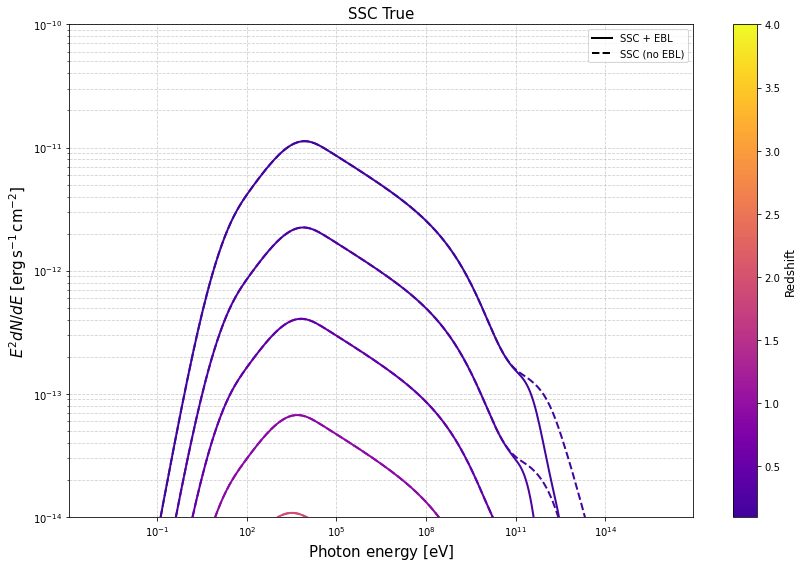

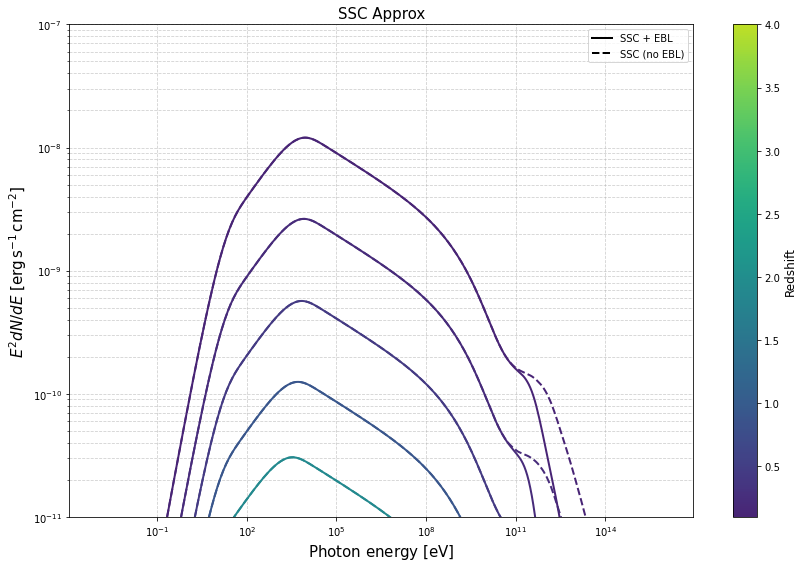

In [15]:
multi_redshift=np.logspace(-1,np.log10(4),6)
#multi_redshift=np.logspace(-1,1,6)
norm = mcolors.Normalize(vmin=np.min(multi_redshift), vmax=np.max(multi_redshift))

emin=1e-3
emax=1e16
bins = int(np.log10(emax/emin) * 20.)  # use 20 bins per decade
ener = Table([np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV], names=['energy'])  # energy in eV
spectrum_energy=np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV


grb = GRBModel1(eiso=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=multi_redshift[0],
                    pars=[eta_e, Ebreak,Index2, Ec,  B],
                    labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)

model=grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)

#SSC=model[0]
SSC=grb.synch_compGG2 + grb.ic_compGG2

ymax1 = 10**np.ceil(np.log10(np.max(SSC).value))
ymin1 = 10**(np.ceil(np.log10(np.max(SSC).value)) - 4)


SSC_approx= grb.synch_comp_approx + grb.ic_comp_approx 

ymax2 = 10**np.ceil(np.log10(np.max(SSC_approx).value))
ymin2 = 10**(np.ceil(np.log10(np.max(SSC_approx).value)) - 4)


fig1, ax1 = plt.subplots(figsize=(12,8))
fig2, ax2 = plt.subplots(figsize=(12,8))

#plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c=cmap2(0.9))


for redshift in multi_redshift:
    
    color1 = cmap1(norm(redshift))
    color2 = cmap2(norm(redshift))
    
    grb = GRBModel1(eiso=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)
    ebl1=EblAbsorptionModel(redshift)
    #ebl2=EblAbsorptionModel(redshift,"Gilmore2012")
    
    model=grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)
    
    #SSC=model[0]
    SSC=grb.synch_compGG2 + grb.ic_compGG2

    trasmission2=ebl1.transmission(spectrum_energy)
    SSC_ebl2=SSC*trasmission2

    
    ax1.loglog(spectrum_energy,SSC_ebl2,lw=2,c=color1)
    ax1.loglog(spectrum_energy,SSC,lw=2,ls='--',c=color1)

    SSC_approx= grb.synch_comp_approx + grb.ic_comp_approx 

    SSC_approx_ebl2=SSC_approx*trasmission2

    ax2.loglog(spectrum_energy,SSC_approx_ebl2,lw=2,c=color2)
    ax2.loglog(spectrum_energy,SSC_approx,lw=2,ls='--',c=color2)

    
#------------------------------------ Aggiungi colorbar --------------------------------

sm1 = cm.ScalarMappable(cmap=cmap1, norm=norm)
sm1.set_array([])

sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm)
sm2.set_array([])

cbar1 = fig1.colorbar(sm1, ax=ax1)
cbar1.set_label('Redshift', fontsize=12)

cbar2 = fig2.colorbar(sm2, ax=ax2)
cbar2.set_label('Redshift', fontsize=12)
#-------------------------- legend --------------------------------

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='k', lw=2, label="SSC + EBL"),        # linea nera continua
    Line2D([0], [0], color='k', lw=2, ls='--', label="SSC (no EBL)") # linea nera tratteggiata
]
#-
ax1.set_xlabel(f'Photon energy [{spectrum_energy.unit.to_string("latex_inline")}]', fontsize=15)
ax1.set_ylabel(f'$E^2 dN/dE$ [{model[0].unit.to_string("latex_inline")}]', fontsize=15)
ax1.set_title("SSC True",fontsize=15)


ax1.set_ylim(ymin1, ymax1)
#plt.xlim(1e-3,5e16)
ax1.legend(handles=legend_elements, loc="upper right")

ax1.grid(True, which="both", linestyle="--", alpha=0.6)

fig1.tight_layout()
fig1.savefig("/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/plot3.jpg", format="jpg", dpi=300)

#----------------------------------------------------------------------------------------------

ax2.set_xlabel(f'Photon energy [{spectrum_energy.unit.to_string("latex_inline")}]', fontsize=15)
ax2.set_ylabel(f'$E^2 dN/dE$ [{model[0].unit.to_string("latex_inline")}]', fontsize=15)
ax2.set_title("SSC Approx",fontsize=15)

ax2.set_ylim(ymin2, ymax2)
#plt.xlim(1e-3,5e16)
ax2.legend(handles=legend_elements, loc="upper right")

ax2.grid(True, which="both", linestyle="--", alpha=0.6)

fig2.tight_layout()
fig2.savefig("/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/plot4.jpg", format="jpg", dpi=300)
plt.show()

In [19]:
############################################### PARAMETERS ####################################

Eiso = 8e51  # erg
density = 0.01 #0.5  # cm-3
redshift = 0.1
tstart = 68   # s
tstop = 110   # s

#-----list of parameters of a electron distribution (log10) ------

eta_e=-1.44
Ebreak=-1.62
Index2=3.3
Ec=1.32  # cutoff energy in TeV
B=0.25

#################################################################################################

the code can be used only for computation of theoretical curves

 ------------------ Starting GRB initialization ------------------
Gamma 183.86857615320758
 ------------------ Ending GRB initialization ------------------


-------------------- Starting GRB computation --------------------
Theta max (deg): 1.2464507141305297  = 4\Gamma
Gamma factor ISO : 183.86857615320758
 Doppler factor(theta) [367.73443295 307.07835525 205.42625061 132.38664676  88.38922054
  61.92794204  45.33870039  34.43668453  26.95743133  21.63269186]
-------------------- ending GRB computation --------------------

the code can be used only for computation of theoretical curves

 ------------------ Starting GRB initialization ------------------
Gamma 183.86857615320758
 ------------------ Ending GRB initialization ------------------


-------------------- Starting GRB computation --------------------
Theta max (deg): 1.2464507141305297  = 4\Gamma
Gamma factor ISO : 183.86857615320758
 Doppler factor(theta) [36

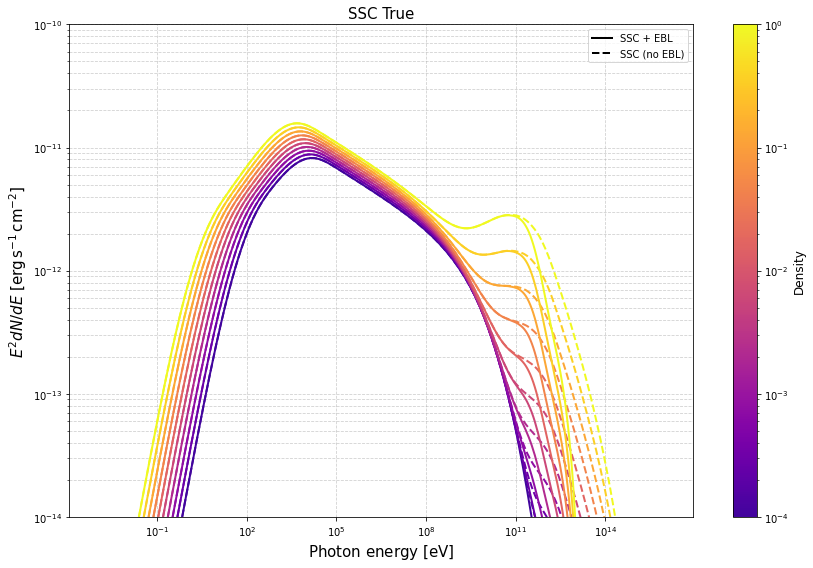

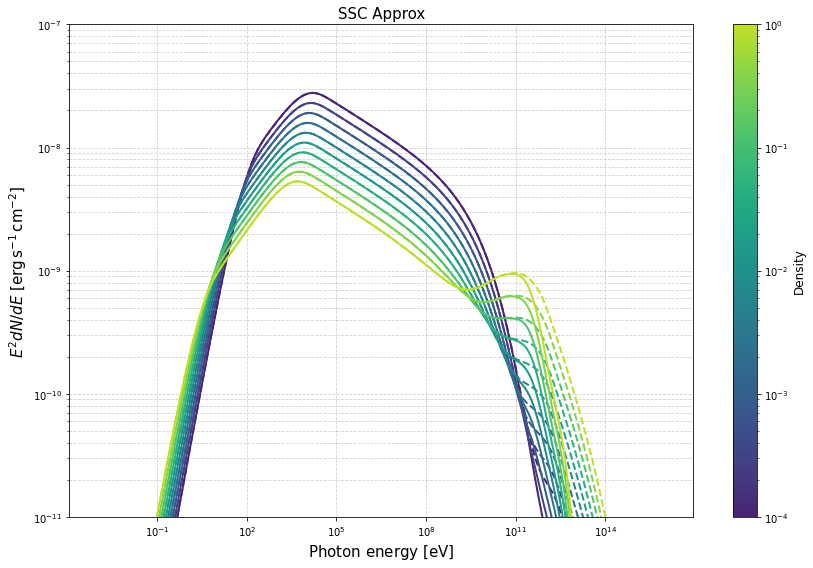

In [20]:
multi_density=np.logspace(-4,0,10)
#multi_density = [0.01]
norm = mcolors.LogNorm(vmin=np.min(multi_density), vmax=np.max(multi_density))

emin=1e-3
emax=1e16
bins = int(np.log10(emax/emin) * 20.)  # use 20 bins per decade
ener = Table([np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV], names=['energy'])  # energy in eV
spectrum_energy=np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV


grb = GRBModel1(eiso=Eiso, dens=multi_density[0], tstart=tstart, tstop=tstop, redshift=redshift,
                    pars=[eta_e, Ebreak,Index2, Ec,  B],
                    labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)

model=grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)

#SSC=model[0]
SSC=grb.synch_compGG2 + grb.ic_compGG2

ymax1 = 10**(np.ceil(np.log10(np.max(SSC).value))+1)
ymin1 = 10**(np.ceil(np.log10(np.max(SSC).value)) -3)


SSC_approx= grb.synch_comp_approx + grb.ic_comp_approx 

ymax2 = 10**(np.ceil(np.log10(np.max(SSC_approx).value)))
ymin2 = 10**(np.ceil(np.log10(np.max(SSC_approx).value))-4)

fig1, ax1 = plt.subplots(figsize=(12,8))
fig2, ax2 = plt.subplots(figsize=(12,8))

#plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c=cmap2(0.9))


for density in multi_density:

    color1 = cmap1(norm(density))
    color2 = cmap2(norm(density))

    grb = GRBModel1(eiso=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)
    #ebl1=EblAbsorptionModel(redshift)
    ebl2=EblAbsorptionModel(redshift,"Gilmore2012")
    
    model=grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)
    
    #SSC=model[0]
    SSC=grb.synch_compGG2 + grb.ic_compGG2

    trasmission2=ebl2.transmission(spectrum_energy)
    SSC_ebl2=SSC*trasmission2

    
    ax1.loglog(spectrum_energy,SSC_ebl2,lw=2,c=color1)
    ax1.loglog(spectrum_energy,SSC,lw=2,ls='--',c=color1)

    SSC_approx= grb.synch_comp_approx + grb.ic_comp_approx 

    SSC_approx_ebl2=SSC_approx*trasmission2

    ax2.loglog(spectrum_energy,SSC_approx_ebl2,lw=2,c=color2)
    ax2.loglog(spectrum_energy,SSC_approx,lw=2,ls='--',c=color2)


#------------------------------------ Aggiungi colorbar --------------------------------
sm1 = cm.ScalarMappable(cmap=cmap1, norm=norm)
sm1.set_array([])

sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm)
sm2.set_array([])

cbar1 = fig1.colorbar(sm1, ax=ax1)
cbar1.set_label('Density', fontsize=12)

cbar2 = fig2.colorbar(sm2, ax=ax2)
cbar2.set_label('Density', fontsize=12)

#-------------------------- legend --------------------------------

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='k', lw=2, label="SSC + EBL"),        # linea nera continua
    Line2D([0], [0], color='k', lw=2, ls='--', label="SSC (no EBL)") # linea nera tratteggiata
]

ax1.set_xlabel(f'Photon energy [{spectrum_energy.unit.to_string("latex_inline")}]', fontsize=15)
ax1.set_ylabel(f'$E^2 dN/dE$ [{model[0].unit.to_string("latex_inline")}]', fontsize=15)
ax1.set_title("SSC True",fontsize=15)

ax1.set_ylim(ymin1, ymax1)
#plt.xlim(1e-3,5e16)
ax1.legend(handles=legend_elements, loc="upper right")

ax1.grid(True, which="both", linestyle="--", alpha=0.6)

fig1.tight_layout()
fig1.savefig("/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/density1.jpg", format="jpg", dpi=300)

#----------------------------------------------------------------------------------------------

ax2.set_xlabel(f'Photon energy [{spectrum_energy.unit.to_string("latex_inline")}]', fontsize=15)
ax2.set_ylabel(f'$E^2 dN/dE$ [{model[0].unit.to_string("latex_inline")}]', fontsize=15)
ax2.set_title("SSC Approx",fontsize=15)

ax2.set_ylim(ymin2, ymax2)
#plt.xlim(1e-3,5e16)
ax1.legend(handles=legend_elements, loc="upper right")

ax2.grid(True, which="both", linestyle="--", alpha=0.6)

fig2.tight_layout()
fig2.savefig("/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/density2.jpg", format="jpg", dpi=300)
plt.show()

In [21]:
############################################### PARAMETERS ####################################

Eiso = 8e51  # erg
density = 0.01 #0.5  # cm-3
redshift = 0.1
tstart = 68   # s
tstop = 110   # s

#-----list of parameters of a electron distribution (log10) ------

eta_e=-1.44
Ebreak=-1.62
Index2=3.3
Ec=1.32  # cutoff energy in TeV
B=0.25

#################################################################################################

the code can be used only for computation of theoretical curves

 ------------------ Starting GRB initialization ------------------
Gamma 123.84907204129264
 ------------------ Ending GRB initialization ------------------


-------------------- Starting GRB computation --------------------
Theta max (deg): 1.8505033124181756  = 4\Gamma
Gamma factor ISO : 123.84907204129264
 Doppler factor(theta) [247.69410684 206.83905181 138.37030124  89.17322022  59.53777334
  41.71410844  30.53997316  23.19661058  18.15874108  14.57210428]
-------------------- ending GRB computation --------------------

the code can be used only for computation of theoretical curves

 ------------------ Starting GRB initialization ------------------
Gamma 123.84907204129264
 ------------------ Ending GRB initialization ------------------


-------------------- Starting GRB computation --------------------
Theta max (deg): 1.8505033124181756  = 4\Gamma
Gamma factor ISO : 123.84907204129264
 Doppler factor(theta) [24

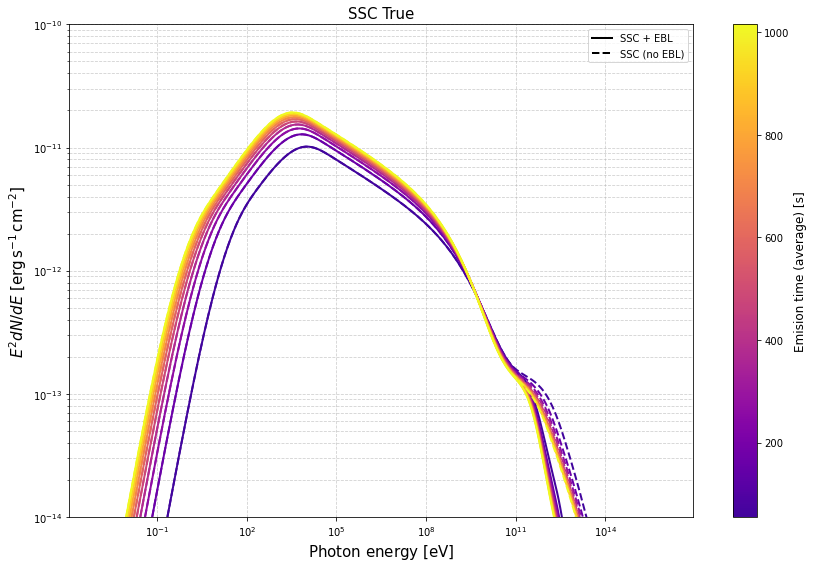

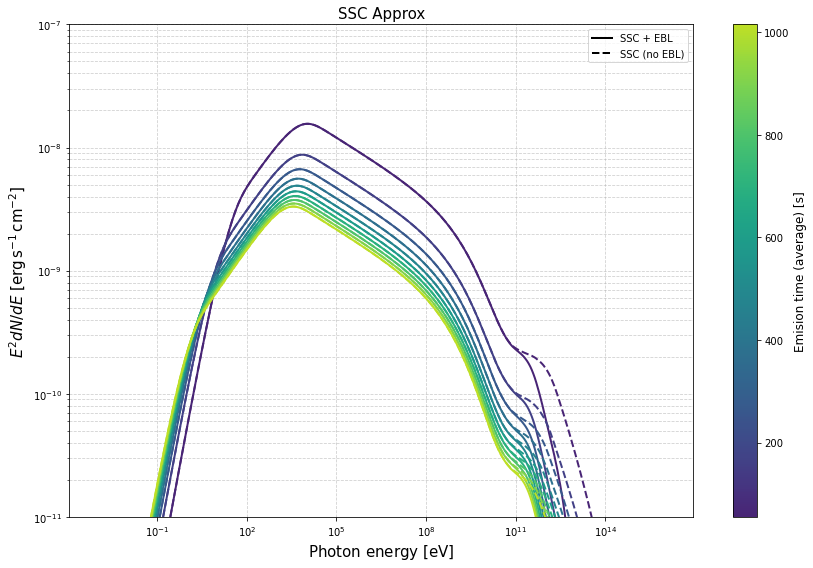

In [24]:
multi_tstart=np.linspace(40,1000,10)

tmedio= multi_tstart + 15
norm = mcolors.Normalize(vmin=np.min(tmedio), vmax=np.max(tmedio))

emin=1e-3
emax=1e16
bins = int(np.log10(emax/emin) * 20.)  # use 20 bins per decade
ener = Table([np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV], names=['energy'])  # energy in eV
spectrum_energy=np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV


grb = GRBModel1(eiso=Eiso, dens=density,tstart=multi_tstart[0], tstop=multi_tstart[0]+30, redshift=redshift,
                    pars=[eta_e, Ebreak,Index2, Ec,  B],
                    labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)

model=grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)

#SSC=model[0]
SSC=grb.synch_compGG2 + grb.ic_compGG2

ymax1 = 10**(np.ceil(np.log10(np.max(SSC).value)))
ymin1 = 10**(np.ceil(np.log10(np.max(SSC).value))-4)


SSC_approx= grb.synch_comp_approx + grb.ic_comp_approx 

ymax2 = 10**(np.ceil(np.log10(np.max(SSC_approx).value)))
ymin2 = 10**(np.ceil(np.log10(np.max(SSC_approx).value)) -4)

fig1, ax1 = plt.subplots(figsize=(12,8))
fig2, ax2 = plt.subplots(figsize=(12,8))

#plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c=cmap2(0.9))


for tstart in multi_tstart:

    color1 = cmap1(norm(tstart+15))
    color2 = cmap2(norm(tstart+15))

    grb = GRBModel1(eiso=Eiso, dens=density, tstart=tstart, tstop=tstart+30, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)
    #ebl1=EblAbsorptionModel(redshift)
    ebl2=EblAbsorptionModel(redshift,"Gilmore2012")
    
    model=grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)
    
    #SSC=model[0]
    SSC=grb.synch_compGG2 + grb.ic_compGG2

    trasmission2=ebl2.transmission(spectrum_energy)
    SSC_ebl2=SSC*trasmission2

    
    ax1.loglog(spectrum_energy,SSC_ebl2,lw=2,c=color1)
    ax1.loglog(spectrum_energy,SSC,lw=2,ls='--',c=color1)

    SSC_approx= grb.synch_comp_approx + grb.ic_comp_approx 

    SSC_approx_ebl2=SSC_approx*trasmission2

    ax2.loglog(spectrum_energy,SSC_approx_ebl2,lw=2,c=color2)
    ax2.loglog(spectrum_energy,SSC_approx,lw=2,ls='--',c=color2)




#------------------------------------ Aggiungi colorbar --------------------------------
sm1 = cm.ScalarMappable(cmap=cmap1, norm=norm)
sm1.set_array([])

sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm)
sm2.set_array([])

cbar1 = fig1.colorbar(sm1, ax=ax1)
cbar1.set_label('Emision time (average) [s]', fontsize=12)

cbar2 = fig2.colorbar(sm2, ax=ax2)
cbar2.set_label('Emision time (average) [s]', fontsize=12)

#-------------------------- legend --------------------------------

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='k', lw=2, label="SSC + EBL"),        # linea nera continua
    Line2D([0], [0], color='k', lw=2, ls='--', label="SSC (no EBL)") # linea nera tratteggiata
]

ax1.set_xlabel(f'Photon energy [{spectrum_energy.unit.to_string("latex_inline")}]', fontsize=15)
ax1.set_ylabel(f'$E^2 dN/dE$ [{model[0].unit.to_string("latex_inline")}]', fontsize=15)
ax1.set_title("SSC True",fontsize=15)

ax1.set_ylim(ymin1, ymax1)
#plt.xlim(1e-3,5e16)
ax1.legend(handles=legend_elements, loc="upper right")

ax1.grid(True, which="both", linestyle="--", alpha=0.6)

fig1.tight_layout()
fig1.savefig("/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/times1.jpg", format="jpg", dpi=300)

#----------------------------------------------------------------------------------------------

ax2.set_xlabel(f'Photon energy [{spectrum_energy.unit.to_string("latex_inline")}]', fontsize=15)
ax2.set_ylabel(f'$E^2 dN/dE$ [{model[0].unit.to_string("latex_inline")}]', fontsize=15)
ax2.set_title("SSC Approx",fontsize=15)

ax2.set_ylim(ymin2, ymax2)
#plt.xlim(1e-3,5e16)
ax2.legend(handles=legend_elements, loc="upper right")

ax2.grid(True, which="both", linestyle="--", alpha=0.6)

fig2.tight_layout()
fig2.savefig("/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/times2.jpg", format="jpg", dpi=300)
plt.show()

In [25]:
############################################### PARAMETERS ####################################

Eiso = 8e51  # erg
density = 0.01 #0.5  # cm-3
redshift = 0.1
tstart = 68   # s
tstop = 110   # s

#-----list of parameters of a electron distribution (log10) ------

eta_e=-1.44
Ebreak=-1.62
Index2=3.3
Ec=1.32  # cutoff energy in TeV
B=0.25   #B=10**(0.25)

#################################################################################################

the code can be used only for computation of theoretical curves

 ------------------ Starting GRB initialization ------------------
Gamma 103.39689877485736
 ------------------ Ending GRB initialization ------------------


-------------------- Starting GRB computation --------------------
Theta max (deg): 2.216537640566633  = 4\Gamma
Gamma factor ISO : 103.39689877485736
 Doppler factor(theta) [206.7889617  172.68148432 115.52048342  74.44802901  49.70656395
  34.82623565  25.49733667  19.36660865  15.16065578  12.16628778]
-------------------- ending GRB computation --------------------

the code can be used only for computation of theoretical curves

 ------------------ Starting GRB initialization ------------------
Gamma 103.39689877485736
 ------------------ Ending GRB initialization ------------------


-------------------- Starting GRB computation --------------------
Theta max (deg): 2.216537640566633  = 4\Gamma
Gamma factor ISO : 103.39689877485736
 Doppler factor(theta) [206.

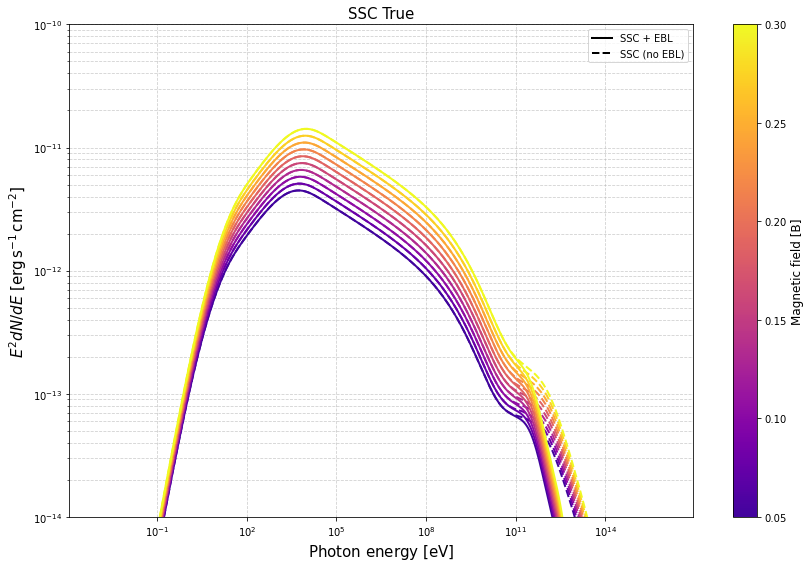

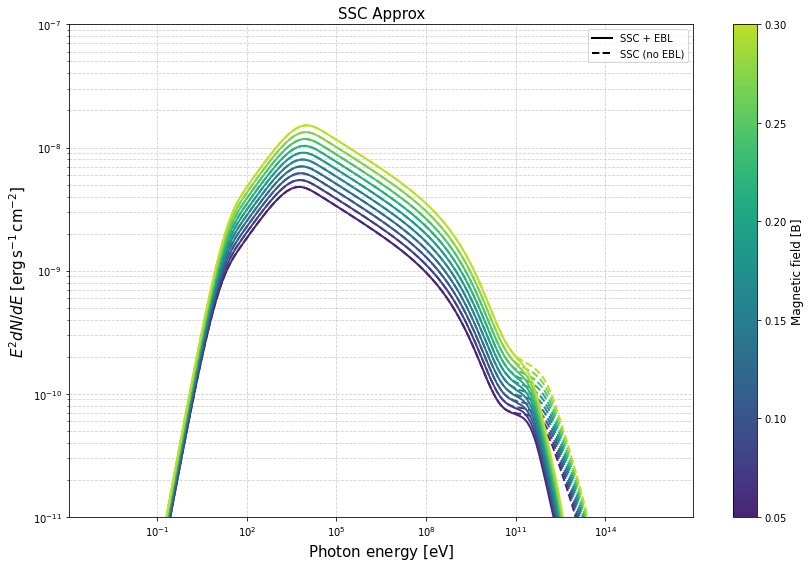

In [28]:
multi_B=np.linspace(0.05,0.3,10)

norm = mcolors.Normalize(vmin=np.min(multi_B), vmax=np.max(multi_B))

emin=1e-3
emax=1e16
bins = int(np.log10(emax/emin) * 20.)  # use 20 bins per decade
ener = Table([np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV], names=['energy'])  # energy in eV
spectrum_energy=np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV


grb = GRBModel1(eiso=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                    pars=[eta_e, Ebreak,Index2, Ec,  multi_B[0]],
                    labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)

model=grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)

#SSC=model[0]
SSC=grb.synch_compGG2 + grb.ic_compGG2

ymax1 = 10**(np.ceil(np.log10(np.max(SSC).value)))
ymin1 = 10**(np.ceil(np.log10(np.max(SSC).value)) -4)


SSC_approx= grb.synch_comp_approx + grb.ic_comp_approx 

ymax2 = 10**(np.ceil(np.log10(np.max(SSC_approx).value)))
ymin2 = 10**(np.ceil(np.log10(np.max(SSC_approx).value))-4)

fig1, ax1 = plt.subplots(figsize=(12,8))
fig2, ax2 = plt.subplots(figsize=(12,8))

#plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c=cmap2(0.9))


for B in multi_B:

    color1 = cmap1(norm(B))
    color2 = cmap2(norm(B))

    grb = GRBModel1(eiso=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)
    #ebl1=EblAbsorptionModel(redshift)
    ebl2=EblAbsorptionModel(redshift,"Gilmore2012")
    
    model=grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)
    
    #SSC=model[0]
    SSC=grb.synch_compGG2 + grb.ic_compGG2

    trasmission2=ebl2.transmission(spectrum_energy)
    SSC_ebl2=SSC*trasmission2

    
    ax1.loglog(spectrum_energy,SSC_ebl2,lw=2,c=color1)
    ax1.loglog(spectrum_energy,SSC,lw=2,ls='--',c=color1)

    SSC_approx= grb.synch_comp_approx + grb.ic_comp_approx 

    SSC_approx_ebl2=SSC_approx*trasmission2

    ax2.loglog(spectrum_energy,SSC_approx_ebl2,lw=2,c=color2)
    ax2.loglog(spectrum_energy,SSC_approx,lw=2,ls='--',c=color2)



#------------------------------------ Aggiungi colorbar --------------------------------
sm1 = cm.ScalarMappable(cmap=cmap1, norm=norm)
sm1.set_array([])

sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm)
sm2.set_array([])

cbar1 = fig1.colorbar(sm1, ax=ax1)
cbar1.set_label('Magnetic field [B]', fontsize=12)

cbar2 = fig2.colorbar(sm2, ax=ax2)
cbar2.set_label('Magnetic field [B]', fontsize=12)

#-------------------------- legend --------------------------------

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='k', lw=2, label="SSC + EBL"),        # linea nera continua
    Line2D([0], [0], color='k', lw=2, ls='--', label="SSC (no EBL)") # linea nera tratteggiata
]

ax1.set_xlabel(f'Photon energy [{spectrum_energy.unit.to_string("latex_inline")}]', fontsize=15)
ax1.set_ylabel(f'$E^2 dN/dE$ [{model[0].unit.to_string("latex_inline")}]', fontsize=15)
ax1.set_title("SSC True",fontsize=15)

ax1.set_ylim(ymin1, ymax1)
#plt.xlim(1e-3,5e16)
ax1.legend(handles=legend_elements, loc="upper right")

ax1.grid(True, which="both", linestyle="--", alpha=0.6)

fig1.tight_layout()
fig1.savefig("/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/Bfield1.jpg", format="jpg", dpi=300)

#----------------------------------------------------------------------------------------------

ax2.set_xlabel(f'Photon energy [{spectrum_energy.unit.to_string("latex_inline")}]', fontsize=15)
ax2.set_ylabel(f'$E^2 dN/dE$ [{model[0].unit.to_string("latex_inline")}]', fontsize=15)
ax2.set_title("SSC Approx",fontsize=15)

ax2.set_ylim(ymin2, ymax2)
#plt.xlim(1e-3,5e16)
ax2.legend(handles=legend_elements, loc="upper right")

ax2.grid(True, which="both", linestyle="--", alpha=0.6)

fig2.tight_layout()
fig2.savefig("/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/Bfield2.jpg", format="jpg", dpi=300)

In [29]:
############################################### PARAMETERS ####################################

Eiso = 8e51  # erg
density = 0.01 #0.5  # cm-3
redshift = 0.1
tstart = 50   # s
tstop = 110   # s

#-----list of parameters of a electron distribution (log10) ------

eta_e=-1.44
Ebreak=-1.62
Index2=3.3
Ec=1.32  # cutoff energy in TeV
B=0.25   #B=10**(0.25)

#################################################################################################

In [ ]:
multi_tstop=np.linspace(10,1000,10)
#multi_B = [0.25]

# Plot
plt.figure(figsize=(12,8))
plt.rc('font', family='sans')
plt.rc('mathtext', fontset='custom')

#plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c=cmap2(0.9))
color=0

ymax=0
ymin=0
for stop in multi_tstop:
    
    grb = GRBModel1(eiso=Eiso, dens=density, tstart=tstart, tstop=tstart+stop, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=None)
    emin=1e-3
    emax=1e16
    bins = int(np.log10(emax/emin) * 20.)  # use 20 bins per decade
    ener = Table([np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV], names=['energy'])  # energy in eV

    model=grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)
    
    SSC=model[0]
    
    max=np.max(SSC).value
    #min=np.min(SSC).value
    
    ordine = int(np.ceil(np.log10(max)))
    max = 10**ordine
    min = 10**(ordine - 4)
    
    if max>ymax:
        ymax=max
        ymin=min
    
    
    #grb.plot_sed(1e-3,1e16,6)
    spectrum_energy=np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV
    
    plt.loglog(spectrum_energy,grb.ic_compGG2,lw=1.5,ls='--',c="black")
    plt.loglog(spectrum_energy,grb.synch_compGG2,lw=1.5,ls=':',c="gray")
    plt.loglog(spectrum_energy,SSC,lw=2,label=f'SSC - 50s+{round(stop,1)*u.s}',c=cmap2(color))
    color=color+0.1

plt.xlabel('Photon energy [{0}]'.format(spectrum_energy.unit.to_string('latex_inline')),fontsize=15)
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(model[0].unit.to_string('latex_inline')),fontsize=15)

plt.ylim(ymin, ymax)
#plt.xlim(1e-3,5e16)
plt.tight_layout()
plt.legend(loc='lower left')


plt.title(f"SSC test",fontsize=15)
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.savefig("/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-April30/plot6", format="pdf", dpi=300)

In [ ]:
import numpy as np

# Carica il file
data = np.load("data/tau_dominguez11.npz")

# Mostra le chiavi (i nomi degli array salvati)
print(data.files)

import pandas as pd

array = data['arr_0']  # ad esempio: shape (100, 5)
df = pd.DataFrame(array)
print(df.head())




In [ ]:
import numpy as np
import pandas as pd

# Carica il file .npz
data = np.load("data/tau_dominguez11.npz")

# Vedi cosa contiene
print("Chiavi trovate:", data.files)

# Supponiamo che ci sia un array chiamato 'tabella'
array = data['arr_0']  # sostituisci con il nome reale

# Converti in DataFrame (se la forma lo consente)
df = pd.DataFrame(array)

# Stampa la tabella
print(df)


In [ ]:
colname = "col%s" % (3)
print(colname)


In [ ]:
import numpy as np
from astropy import units as u

# Carica i dati dal file .dat
filename = "Data/Gilmore2012.dat"

# Leggi la prima riga del file per ottenere i redshift
with open(filename, 'r') as f:
    header = f.readline().strip()  # Leggi la prima riga
    # Estrai i redshift dalla prima riga (dopo "z=")
    redshift_list = [float(z) for z in header.split("z=")[1].split(",")]

# Ora carica il resto dei dati, saltando la prima riga con i redshift
data = np.loadtxt(filename, skiprows=1)

# La prima colonna è l'energia (E_gam in MeV)
energy = data[:, 0] * u.MeV  # Assicurati di avere i giusti unità di misura

# Creiamo un dizionario con i valori per i vari redshift
taus_table = {}  # Questo conterrà i dati dei tau
taus_table["energy"] = energy

# Estrai le colonne dei tau per ciascun redshift
for i, redshift in enumerate(redshift_list):
    column_name = f"z{redshift:.2f}"  # Es. z0.01, z0.02, z1.0, ...
    taus_table[column_name] = data[:, i+1] * u.dimensionless_unscaled  # Salva i valori di tau

#---------------------------------------------------------------------------------------------------------

# Ora, analogamente al codice con .npz, ottieni i valori di tau per un redshift specifico
target_redshift = 9# Ad esempio, scegliamo il redshift 0.2
column_name = f"z{target_redshift:.2f}"  # nome della colonna per il redshift 0.2

# Estrai i valori di tau per questo redshift
taus = taus_table[column_name]  # I valori di tau per il redshift specificato

# Ora puoi lavorare con taus e energy come nel caso precedente
print("Energy:", energy)
print(f"Tau values for redshift {target_redshift}:", taus)
